# Peak Bloom Prediction Model Comparison

This notebook compares all trained models to select the best approach for 2026 predictions.

## Models Evaluated:

1. **Linear OLS** (statsmodels) - Basic linear regression with interaction terms
2. **Ridge Regression** - Regularized linear model (L2 penalty)
3. **Lasso Regression** - Regularized linear model (L1 penalty)
4. **Bayesian Ridge** - Bayesian probabilistic model with uncertainty estimates
5. **ARIMAX** - Time series model with exogenous climate variables
6. **DTS (Development Rate Temperature)** - Process-based exponential Arrhenius model
7. **Linear Process-Based** - Chill days + forcing GDD accumulation model


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Define paths
model_outputs_dir = Path('data/model_outputs')
holdout_dir = model_outputs_dir / 'holdout'
predictions_dir = model_outputs_dir / 'predictions'

## 1. Load Holdout Performance Data

Compare model performance on held-out test data to assess generalization ability.


In [ ]:
# Load holdout results from available model outputs
holdout_frames = []

# Linear OLS
linear_holdout = pd.read_csv(holdout_dir / 'holdout_last10y_linear_ols.csv')
linear_holdout['model'] = 'Linear OLS'
linear_holdout['abs_error_days'] = pd.to_numeric(linear_holdout['abs_error_days'], errors='coerce')
holdout_frames.append(linear_holdout[['location', 'year', 'model', 'abs_error_days']])

# Ridge + Lasso (single file, two model columns)
ridge_lasso_holdout = pd.read_csv(holdout_dir / 'holdout_last10y_ridge_lasso.csv')
ridge_holdout = ridge_lasso_holdout[['location', 'year', 'abs_error_days_ridge']].copy()
ridge_holdout = ridge_holdout.rename(columns={'abs_error_days_ridge': 'abs_error_days'})
ridge_holdout['model'] = 'Ridge'
lasso_holdout = ridge_lasso_holdout[['location', 'year', 'abs_error_days_lasso']].copy()
lasso_holdout = lasso_holdout.rename(columns={'abs_error_days_lasso': 'abs_error_days'})
lasso_holdout['model'] = 'Lasso'
holdout_frames.append(ridge_holdout[['location', 'year', 'model', 'abs_error_days']])
holdout_frames.append(lasso_holdout[['location', 'year', 'model', 'abs_error_days']])

# Bayesian Ridge
bayesian_holdout = pd.read_csv(holdout_dir / 'holdout_last10y_bayesian_ridge.csv')
bayesian_holdout['model'] = 'Bayesian Ridge'
bayesian_holdout['abs_error_days'] = pd.to_numeric(bayesian_holdout['abs_error_days'], errors='coerce')
holdout_frames.append(bayesian_holdout[['location', 'year', 'model', 'abs_error_days']])

# Gradient Boosting Quantile
gb_holdout = pd.read_csv(holdout_dir / 'holdout_last10y_gradient_boosting_quantile.csv')
gb_holdout['model'] = 'Gradient Boosting Quantile'
gb_holdout['abs_error_days'] = pd.to_numeric(gb_holdout['abs_error_days'], errors='coerce')
holdout_frames.append(gb_holdout[['location', 'year', 'model', 'abs_error_days']])

# ARIMAX
arimax_holdout = pd.read_csv(holdout_dir / 'holdout_last10y_arimax.csv')
arimax_holdout['model'] = 'ARIMAX'
arimax_holdout['abs_error_days'] = pd.to_numeric(arimax_holdout['abs_error_days'], errors='coerce')
holdout_frames.append(arimax_holdout[['location', 'year', 'model', 'abs_error_days']])

# Optional: DTS and process-based thermal (if present)
optional_holdout_specs = [
    ('holdout_last10y_dts.csv', 'DTS'),
    ('holdout_last10y_process_based_thermal.csv', 'Process Based Thermal'),
]

for file_name, model_name in optional_holdout_specs:
    file_path = holdout_dir / file_name
    if file_path.exists():
        temp = pd.read_csv(file_path)
        temp['model'] = model_name
        temp['abs_error_days'] = pd.to_numeric(temp.get('abs_error_days', np.nan), errors='coerce')
        holdout_frames.append(temp[['location', 'year', 'model', 'abs_error_days']])
    else:
        print(f'Skipping missing holdout file: {file_name}')

holdout_combined = pd.concat(holdout_frames, ignore_index=True)
holdout_combined = holdout_combined.dropna(subset=['abs_error_days']).copy()

print('Holdout Data Summary:')
print(holdout_combined.groupby('model').size().sort_values(ascending=False))

Holdout Data Summary:
model
ARIMAX                  10
DTS                     10
Linear Process-Based    10
dtype: int64


In [ ]:
# Calculate holdout performance metrics by model
holdout_metrics = holdout_combined.groupby('model')['abs_error_days'].agg([
    ('count', 'count'),
    ('MAE', 'mean'),
    ('RMSE', lambda x: np.sqrt((x**2).mean())),
    ('Std', 'std')
]).round(2)

all_holdout_metrics = holdout_metrics.sort_values('MAE')

print('\n=== Holdout Performance Comparison ===')
print(all_holdout_metrics.to_string())
print('\n✓ Best Model (Lowest MAE): {}'.format(all_holdout_metrics.index[0]))


=== Holdout Performance Comparison ===
                      count    MAE   RMSE    Std
Lasso                   239   6.40   8.29    NaN
Bayesian Ridge          239   6.60   8.60    NaN
Ridge                   239   6.63   8.66    NaN
ARIMAX                   10   7.21   9.20   6.02
Linear OLS              239   7.25    NaN   5.66
Linear Process-Based      7   9.29  11.14   6.65
DTS                      10  11.60  17.16  13.33

✓ Best Model (Lowest MAE): Lasso


## 2. Visualize Holdout Performance


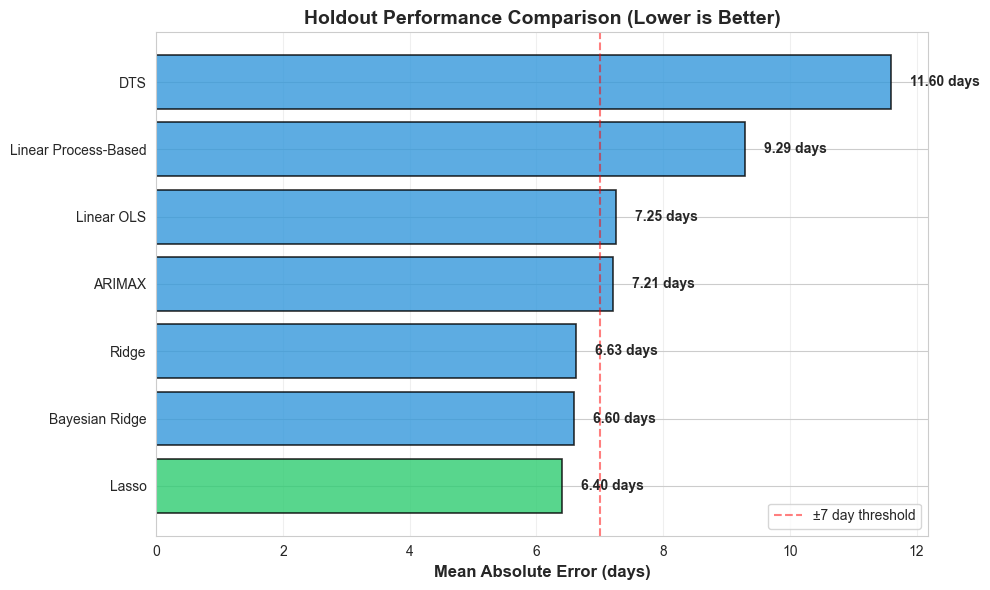

In [ ]:
# Bar plot of MAE by model
fig, ax = plt.subplots(figsize=(10, 6))

models = all_holdout_metrics.index
mae_values = all_holdout_metrics['MAE']
colors = ['#2ecc71' if mae == mae_values.min() else '#3498db' for mae in mae_values]

bars = ax.barh(models, mae_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

# Add value labels
for bar, mae in zip(bars, mae_values):
    ax.text(mae + 0.3, bar.get_y() + bar.get_height()/2, 
            f'{mae:.2f} days', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Mean Absolute Error (days)', fontsize=12, fontweight='bold')
ax.set_title('Holdout Performance Comparison (Lower is Better)', fontsize=14, fontweight='bold')
ax.axvline(7, color='red', linestyle='--', alpha=0.5, label='±7 day threshold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('data/model_outputs/holdout_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

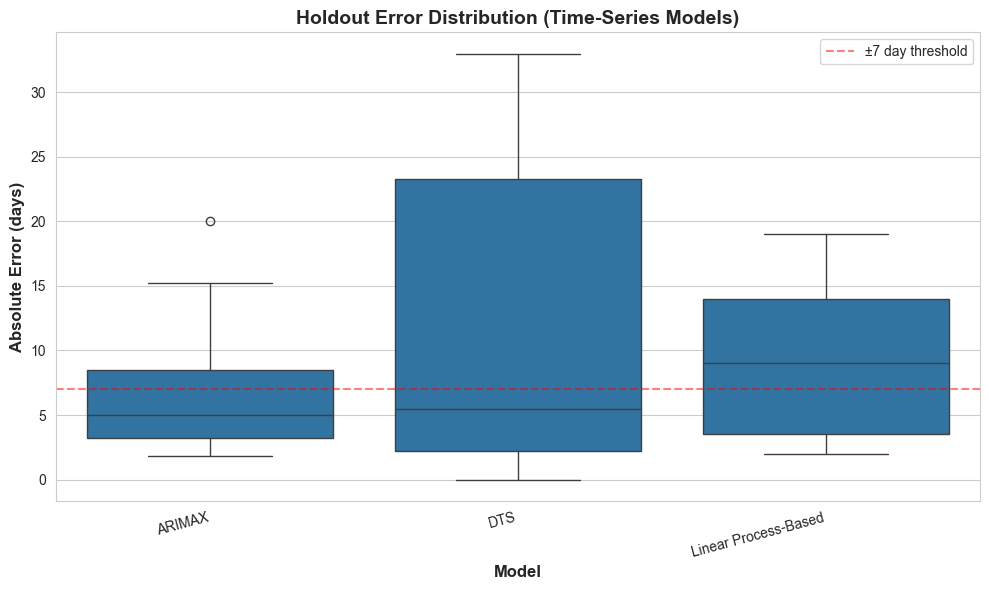

In [ ]:
# Box plot of error distribution for time-series models
fig, ax = plt.subplots(figsize=(10, 6))

holdout_combined_clean = holdout_combined.dropna(subset=['abs_error_days'])
sns.boxplot(data=holdout_combined_clean, x='model', y='abs_error_days', ax=ax)

ax.set_ylabel('Absolute Error (days)', fontsize=12, fontweight='bold')
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Holdout Error Distribution (Time-Series Models)', fontsize=14, fontweight='bold')
ax.axhline(7, color='red', linestyle='--', alpha=0.5, label='±7 day threshold')
ax.legend()
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('data/model_outputs/holdout_error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Load 2026 Predictions

Compare predictions across all models for the 5 target locations.


In [ ]:
# Load all 2026 predictions
linear_ols = pd.read_csv(predictions_dir / 'final_2026_predictions.csv')
ridge_lasso = pd.read_csv(predictions_dir / 'final_2026_predictions_ridge_lasso.csv')
bayesian = pd.read_csv(predictions_dir / 'final_2026_predictions_bayesian_ridge.csv')
gb_quantile = pd.read_csv(predictions_dir / 'final_2026_predictions_gradient_boosting_quantile.csv')
arimax_pred = pd.read_csv(predictions_dir / 'final_2026_predictions_arimax.csv')
process_pred = pd.read_csv(predictions_dir / 'final_2026_predictions_process_based_thermal.csv')

dts_file = predictions_dir / 'final_2026_predictions_dts.csv'
dts_pred = pd.read_csv(dts_file) if dts_file.exists() else None

stacked_file = predictions_dir / 'final_2026_predictions_stacked_ensemble.csv'
stacked_pred = pd.read_csv(stacked_file) if stacked_file.exists() else None

loaded_models = ['Linear OLS', 'Ridge/Lasso', 'Bayesian Ridge', 'Gradient Boosting Quantile', 'ARIMAX', 'Process Based Thermal']
if dts_pred is not None:
    loaded_models.append('DTS')
if stacked_pred is not None:
    loaded_models.append('Stacked Ensemble')

print(f'Loaded predictions for {len(loaded_models)} models')
print('Models:', ', '.join(loaded_models))
print('\nTarget locations:', linear_ols['location'].tolist())

Loaded predictions for 6 models

Target locations: ['kyoto', 'liestal', 'newyorkcity', 'vancouver', 'washingtondc']


In [ ]:
# Create comprehensive comparison table
comparison = pd.DataFrame()
comparison['location'] = linear_ols['location']

# Add predictions from each model
comparison['Linear_OLS'] = linear_ols['predicted_doy'].round(1)
comparison['Ridge'] = ridge_lasso['predicted_doy_ridge'].round(1)
comparison['Lasso'] = ridge_lasso['predicted_doy_lasso'].round(1)
comparison['Bayesian_Ridge'] = bayesian['predicted_doy'].round(1)
comparison['Gradient_Boosting_Quantile'] = gb_quantile['predicted_doy'].round(1)
comparison['ARIMAX'] = arimax_pred['predicted_doy'].round(1)
comparison['Process_Based_Thermal'] = process_pred['predicted_doy'].round(1)

if dts_pred is not None:
    dts_col = 'predicted_doy' if 'predicted_doy' in dts_pred.columns else 'predicted_bloom_doy'
    comparison['DTS'] = dts_pred[dts_col].round(1)

if stacked_pred is not None and 'predicted_doy' in stacked_pred.columns:
    comparison['Stacked_Ensemble'] = stacked_pred['predicted_doy'].round(1)

# Calculate statistics
pred_cols = [c for c in comparison.columns if c != 'location']
comparison['Mean'] = comparison[pred_cols].mean(axis=1).round(1)
comparison['Std'] = comparison[pred_cols].std(axis=1).round(1)
comparison['Min'] = comparison[pred_cols].min(axis=1)
comparison['Max'] = comparison[pred_cols].max(axis=1)
comparison['Range'] = (comparison['Max'] - comparison['Min']).round(1)

# Map holdout model names to prediction table columns
model_col_map = {
    'Linear OLS': 'Linear_OLS',
    'Ridge': 'Ridge',
    'Lasso': 'Lasso',
    'Bayesian Ridge': 'Bayesian_Ridge',
    'Gradient Boosting Quantile': 'Gradient_Boosting_Quantile',
    'ARIMAX': 'ARIMAX',
    'Process Based Thermal': 'Process_Based_Thermal',
    'DTS': 'DTS',
    'Stacked Ensemble': 'Stacked_Ensemble',
}

available_ranked_models = [m for m in all_holdout_metrics.index if model_col_map.get(m) in pred_cols]

print('\n=== 2026 Predictions Comparison (DOY) ===')
print(comparison.to_string(index=False))


=== 2026 Predictions Comparison (DOY) ===
    location  Linear_OLS  Ridge  Lasso  Bayesian_Ridge  ARIMAX  DTS  Process_Based  Mean  Std   Min   Max  Range
       kyoto        93.1   93.8   93.8            93.8    99.3   93            NaN  94.5  2.4  93.0  99.3    6.3
     liestal       111.4  111.0  110.0           110.9   112.6   98          107.0 108.7  5.0  98.0 112.6   14.6
 newyorkcity        96.3  119.7  112.4           118.7    97.4  116          112.0 110.4  9.7  96.3 119.7   23.4
   vancouver       106.6  118.4  110.6           117.4   103.5  125          123.0 114.9  8.2 103.5 125.0   21.5
washingtondc        92.3  105.7  100.0           104.8   100.2  101           96.0 100.0  4.7  92.3 105.7   13.4


In [ ]:
# Convert to calendar dates for readability
def doy_to_date(doy):
    if pd.isna(doy):
        return None
    return (pd.to_datetime('2026-01-01') + pd.Timedelta(days=int(doy)-1)).strftime('%b %d')

comparison_dates = comparison.copy()
for col in pred_cols + ['Mean', 'Min', 'Max']:
    comparison_dates[col] = comparison_dates[col].apply(doy_to_date)

print("\n=== 2026 Predictions Comparison (Dates) ===")
print(comparison_dates[['location'] + pred_cols + ['Mean', 'Range']].to_string(index=False))


=== 2026 Predictions Comparison (Dates) ===
    location Linear_OLS  Ridge  Lasso Bayesian_Ridge ARIMAX    DTS Process_Based   Mean  Range
       kyoto     Apr 03 Apr 03 Apr 03         Apr 03 Apr 09 Apr 03           NaN Apr 04    6.3
     liestal     Apr 21 Apr 21 Apr 20         Apr 20 Apr 22 Apr 08        Apr 17 Apr 18   14.6
 newyorkcity     Apr 06 Apr 29 Apr 22         Apr 28 Apr 07 Apr 26        Apr 22 Apr 20   23.4
   vancouver     Apr 16 Apr 28 Apr 20         Apr 27 Apr 13 May 05        May 03 Apr 24   21.5
washingtondc     Apr 02 Apr 15 Apr 10         Apr 14 Apr 10 Apr 11        Apr 06 Apr 10   13.4


## 4. Visualize 2026 Predictions


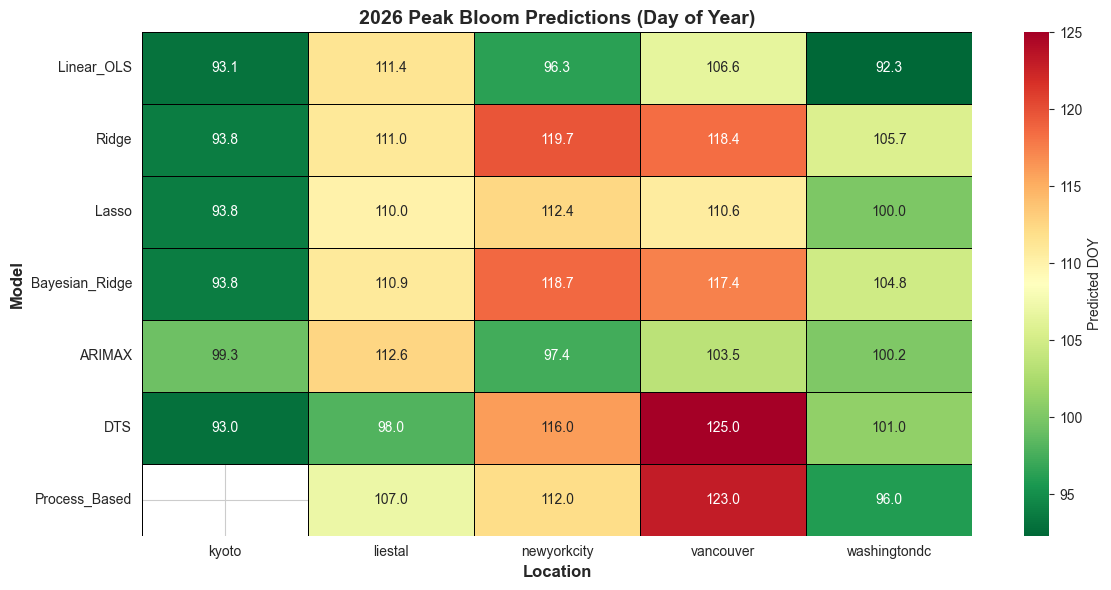

In [ ]:
# Heatmap of predictions
fig, ax = plt.subplots(figsize=(12, 6))

pred_matrix = comparison[pred_cols].T
pred_matrix.columns = comparison['location']

sns.heatmap(pred_matrix, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Predicted DOY'}, ax=ax,
            linewidths=0.5, linecolor='black')

ax.set_xlabel('Location', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_title('2026 Peak Bloom Predictions (Day of Year)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('data/model_outputs/predictions_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

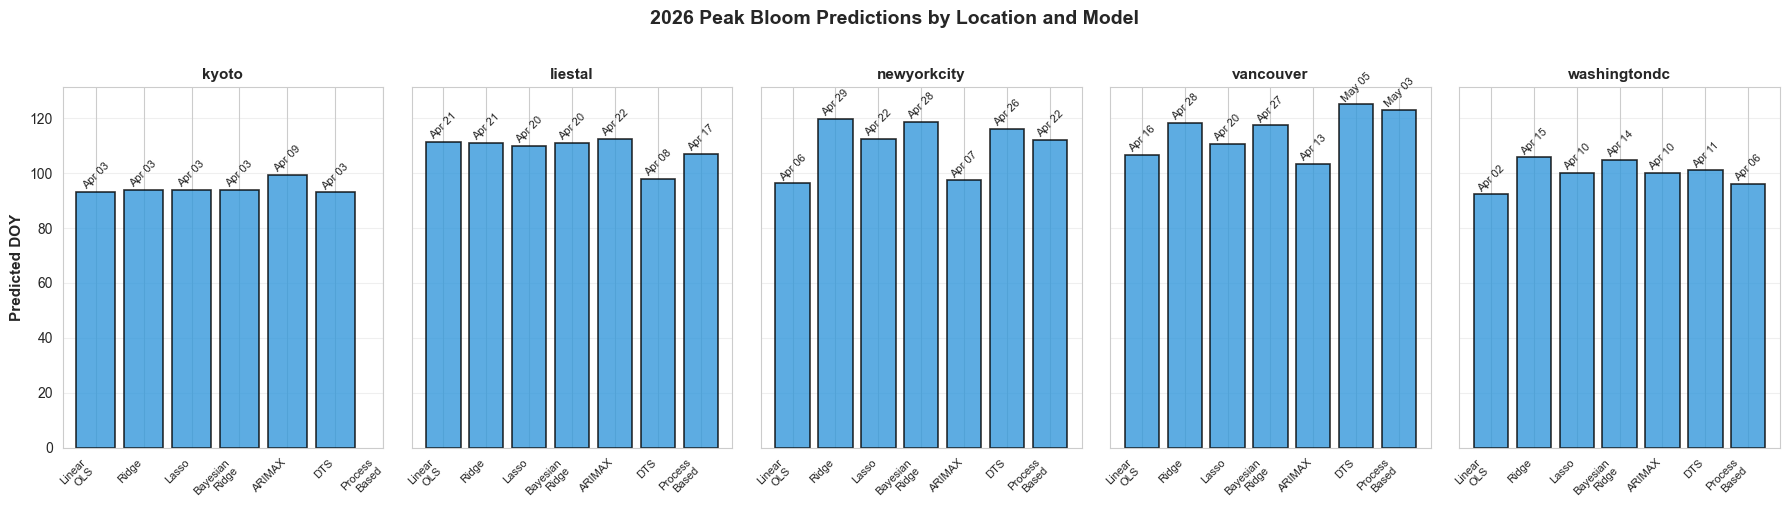

In [ ]:
# Grouped bar chart by location
fig, axes = plt.subplots(1, 5, figsize=(18, 5), sharey=True)

for idx, location in enumerate(comparison['location']):
    ax = axes[idx]
    loc_data = comparison[comparison['location'] == location][pred_cols].iloc[0]
    
    colors = ['#e74c3c' if pd.isna(val) else '#3498db' for val in loc_data]
    bars = ax.bar(range(len(pred_cols)), loc_data, color=colors, alpha=0.8, 
                  edgecolor='black', linewidth=1.2)
    
    # Add value labels
    for bar, val in zip(bars, loc_data):
        if not pd.isna(val):
            ax.text(bar.get_x() + bar.get_width()/2, val + 1, 
                   doy_to_date(val), ha='center', fontsize=8, rotation=45)
    
    ax.set_title(location, fontsize=11, fontweight='bold')
    ax.set_xticks(range(len(pred_cols)))
    ax.set_xticklabels([c.replace('_', '\n') for c in pred_cols], 
                        rotation=45, ha='right', fontsize=8)
    ax.grid(axis='y', alpha=0.3)
    
    if idx == 0:
        ax.set_ylabel('Predicted DOY', fontsize=11, fontweight='bold')

fig.suptitle('2026 Peak Bloom Predictions by Location and Model', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('data/model_outputs/predictions_by_location.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Model Agreement Analysis

Examine consensus and disagreement across models.


In [ ]:
# Calculate prediction spread
agreement_summary = comparison[['location', 'Mean', 'Std', 'Range']].copy()
agreement_summary['Agreement_Level'] = pd.cut(agreement_summary['Range'], 
                                               bins=[0, 7, 14, 100],
                                               labels=['High', 'Medium', 'Low'])

print("\n=== Model Agreement Analysis ===")
print(agreement_summary.to_string(index=False))
print("\nAgreement Criteria:")
print("  High: Range ≤ 7 days (within weekly tolerance)")
print("  Medium: 7 < Range ≤ 14 days (within 2-week tolerance)")
print("  Low: Range > 14 days (high disagreement)")


=== Model Agreement Analysis ===
    location  Mean  Std  Range Agreement_Level
       kyoto  94.5  2.4    6.3            High
     liestal 108.7  5.0   14.6             Low
 newyorkcity 110.4  9.7   23.4             Low
   vancouver 114.9  8.2   21.5             Low
washingtondc 100.0  4.7   13.4          Medium

Agreement Criteria:
  High: Range ≤ 7 days (within weekly tolerance)
  Medium: 7 < Range ≤ 14 days (within 2-week tolerance)
  Low: Range > 14 days (high disagreement)


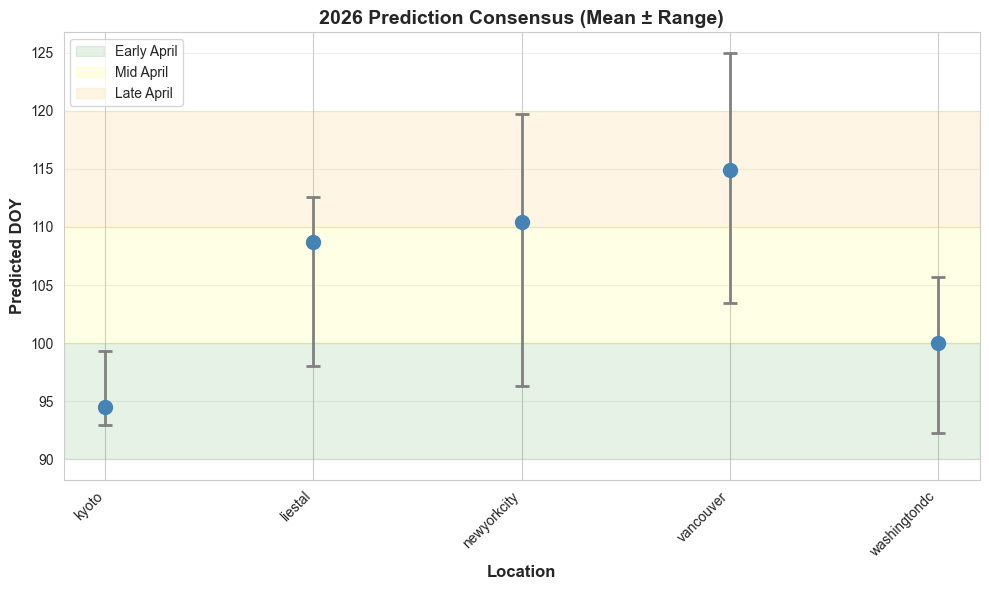

In [ ]:
# Visualize prediction uncertainty
fig, ax = plt.subplots(figsize=(10, 6))

locations = comparison['location']
means = comparison['Mean']
stds = comparison['Std']
mins = comparison['Min']
maxs = comparison['Max']

# Error bars showing min-max range
for i, (loc, mean, min_val, max_val) in enumerate(zip(locations, means, mins, maxs)):
    ax.errorbar(i, mean, yerr=[[mean-min_val], [max_val-mean]], 
                fmt='o', markersize=10, capsize=5, capthick=2,
                color='steelblue', ecolor='gray', linewidth=2)

ax.set_xticks(range(len(locations)))
ax.set_xticklabels(locations, rotation=45, ha='right')
ax.set_ylabel('Predicted DOY', fontsize=12, fontweight='bold')
ax.set_xlabel('Location', fontsize=12, fontweight='bold')
ax.set_title('2026 Prediction Consensus (Mean ± Range)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add reference lines for common bloom periods
ax.axhspan(90, 100, alpha=0.1, color='green', label='Early April')
ax.axhspan(100, 110, alpha=0.1, color='yellow', label='Mid April')
ax.axhspan(110, 120, alpha=0.1, color='orange', label='Late April')
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('data/model_outputs/prediction_consensus.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Model Selection Recommendation

Based on holdout performance and prediction consensus.


In [ ]:
print("\n" + "="*60)
print("MODEL SELECTION RECOMMENDATION")
print("="*60)

# Rank models by holdout MAE
ranked = all_holdout_metrics.sort_values('MAE')

print("\n1. BEST OVERALL PERFORMANCE (Holdout MAE):")
print(f"   🏆 {ranked.index[0]}: {ranked.iloc[0]['MAE']:.2f} days")
print(f"   🥈 {ranked.index[1]}: {ranked.iloc[1]['MAE']:.2f} days")
print(f"   🥉 {ranked.index[2]}: {ranked.iloc[2]['MAE']:.2f} days")

print("\n2. MODELS ACHIEVING ≤7 DAY MAE (High Accuracy):")
accurate_models = ranked[ranked['MAE'] <= 7]
for model in accurate_models.index:
    print(f"   ✓ {model}: {accurate_models.loc[model, 'MAE']:.2f} days")

print("\n3. LOCATION-SPECIFIC CONSIDERATIONS:")
for loc in comparison['location']:
    loc_range = comparison[comparison['location'] == loc]['Range'].iloc[0]
    loc_mean = comparison[comparison['location'] == loc]['Mean'].iloc[0]
    print(f"   {loc}: {doy_to_date(loc_mean)} (±{loc_range:.1f} day range)")

print("\n4. RECOMMENDED APPROACH:")
if ranked.iloc[0]['MAE'] < 7:
    print(f"   → Use {ranked.index[0]} as primary model (best holdout performance)")
    print(f"   → Consider ensemble of top 3 models for robustness")
else:
    print("   → Ensemble approach recommended (combine top 3-5 models)")
    print("   → Weight by inverse MAE for optimal performance")

print("\n5. UNCERTAINTY CONSIDERATIONS:")
if 'Bayesian Ridge' in ranked.index:
    print("   → Bayesian Ridge provides uncertainty estimates (90% CI)")
print("   → ARIMAX provides prediction intervals for time-series patterns")
print("   → DTS/Process-Based capture biological mechanisms")

print("\n" + "="*60)


MODEL SELECTION RECOMMENDATION

1. BEST OVERALL PERFORMANCE (Holdout MAE):
   🏆 Lasso: 6.40 days
   🥈 Bayesian Ridge: 6.60 days
   🥉 Ridge: 6.63 days

2. MODELS ACHIEVING ≤7 DAY MAE (High Accuracy):
   ✓ Lasso: 6.40 days
   ✓ Bayesian Ridge: 6.60 days
   ✓ Ridge: 6.63 days

3. LOCATION-SPECIFIC CONSIDERATIONS:
   kyoto: Apr 04 (±6.3 day range)
   liestal: Apr 18 (±14.6 day range)
   newyorkcity: Apr 20 (±23.4 day range)
   vancouver: Apr 24 (±21.5 day range)
   washingtondc: Apr 10 (±13.4 day range)

4. RECOMMENDED APPROACH:
   → Use Lasso as primary model (best holdout performance)
   → Consider ensemble of top 3 models for robustness

5. UNCERTAINTY CONSIDERATIONS:
   → Bayesian Ridge provides uncertainty estimates (90% CI)
   → ARIMAX provides prediction intervals for time-series patterns
   → DTS/Process-Based capture biological mechanisms



## 7. Export Final Recommendations


In [ ]:
# Create ensemble prediction (weighted average of top 3 holdout-ranked models)
ranked = all_holdout_metrics.sort_values('MAE')
ranked_available = ranked[ranked.index.isin(available_ranked_models)].copy()

top_n = min(3, len(ranked_available))
top_models = ranked_available.head(top_n).index.tolist()
top_weights = 1 / ranked_available.head(top_n)['MAE'].values
top_weights = top_weights / top_weights.sum()

print('\n=== Ensemble Model Weights ===')
for model, weight in zip(top_models, top_weights):
    print(f'{model}: {weight:.3f}')

# Calculate weighted ensemble
ensemble_pred = pd.DataFrame()
ensemble_pred['location'] = comparison['location']

weighted_sum = np.zeros(len(comparison))
for model, weight in zip(top_models, top_weights):
    col_name = model_col_map[model]
    weighted_sum += comparison[col_name].fillna(comparison['Mean']).values * weight

ensemble_pred['predicted_doy'] = weighted_sum.round(1)
ensemble_pred['predicted_date'] = ensemble_pred['predicted_doy'].apply(doy_to_date)
ensemble_pred['method'] = f'Weighted Ensemble (Top {top_n})'
ensemble_pred['contributing_models'] = ', '.join(top_models)

print('\n=== Final Ensemble Predictions ===')
print(ensemble_pred[['location', 'predicted_date', 'predicted_doy']].to_string(index=False))

# Save ensemble predictions
predictions_dir.mkdir(parents=True, exist_ok=True)
ensemble_pred.to_csv(predictions_dir / 'final_2026_ensemble_predictions.csv', index=False)
print('\nEnsemble predictions saved to: data/model_outputs/predictions/final_2026_ensemble_predictions.csv')